# 🎯 Baseline Model
## Bosch Production Line Quality Prediction

### Amaç
En basit ve hızlı şekilde çalışan bir model oluşturmak. Bu model, ilerideki geliştirmeler için referans noktası olacak.

### Strateji
1. **Temizlenmiş Veri:** train_numeric_clean.csv (450K satır, 157 feature)
2. **Model:** XGBoost (dengesiz veriye uygun)
3. **Metrikler:** F1-Score, Precision, Recall, AUC-ROC

### Temiz Veri Özellikleri
- Missing oranı <%50 olan 157 sütun
- Hiç eksik değeri olmayan satırlar
- **Dengesizlik:** 1:228 (448K sağlam, 1.9K hatalı)

In [1]:
# Kütüphaneleri Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_score, recall_score,
    roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier
import joblib

warnings.filterwarnings('ignore')
print("✅ Kütüphaneler yüklendi!")

✅ Kütüphaneler yüklendi!


## 1. Veri Yükleme ve Hazırlama

In [ ]:
# Temizlenmiş Veriyi Yükle
DATA_PATH = '../data/train_numeric_clean.csv'

print(f"📂 Veri yükleniyor...")
df = pd.read_csv(DATA_PATH)
print(f"✅ Veri yüklendi: {df.shape[0]:,} satır x {df.shape[1]:,} sütun")
print(f"📋 Bu veri önceden temizlendi - eksik değer yok!")

📂 Veri yükleniyor...
✅ Veri yüklendi: 100,000 satır x 970 sütun
✅ Veri yüklendi: 100,000 satır x 970 sütun


In [3]:
# Feature ve Target ayırma
X = df.drop(['Id', 'Response'], axis=1)
y = df['Response']

print(f"📊 Hedef değişken dağılımı:")
print(f"   Sağlam (0): {(y==0).sum():,}")
print(f"   Hatalı (1): {(y==1).sum():,}")
print(f"   Dengesizlik oranı: 1:{int((y==0).sum()/(y==1).sum())}")

📊 Hedef değişken dağılımı:
   Sağlam (0): 99,432
   Hatalı (1): 568
   Dengesizlik oranı: 1:175


## 2. Veri Kontrol

✅ **Not:** Temizlenmiş veri kullanıyoruz - eksik değer yok!
- 157 feature (missing oranı <%50 olanlar)
- Tüm satırlar eksiksiz

In [ ]:
# Veri zaten temiz - eksik değer yok
print(f"📊 Veri Boyutu: {X.shape[0]:,} satır x {X.shape[1]:,} sütun")
print(f"✅ Eksik değer sayısı: {X.isnull().sum().sum()}")
print(f"💾 Bellek kullanımı: {X.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# X_cleaned olarak isimlendir (sonraki cell'ler için)
X_cleaned = X

🗑️ Çıkarılacak sütun sayısı (>%90 eksik): 634
✅ Kalan sütun sayısı: 334
✅ Eksik veriler -999 ile dolduruldu

💾 Bellek kullanımı: 254.8 MB
✅ Eksik veriler -999 ile dolduruldu

💾 Bellek kullanımı: 254.8 MB


## 3. Train/Test Split

In [5]:
# Train/Test split (stratified - sınıf oranlarını korur)
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Dengesiz veri için önemli!
)

print(f"📊 Veri Bölümü:")
print(f"   Train: {X_train.shape[0]:,} satır ({y_train.sum()} hatalı)")
print(f"   Test:  {X_test.shape[0]:,} satır ({y_test.sum()} hatalı)")

📊 Veri Bölümü:
   Train: 80,000 satır (454 hatalı)
   Test:  20,000 satır (114 hatalı)


## 4. Baseline Model: XGBoost

XGBoost'u seçme nedenleri:
- **scale_pos_weight** parametresi ile dengesiz veriyi ele alır
- Eksik verileri otomatik işleyebilir
- Hızlı ve güçlü

In [6]:
# Dengesizlik oranını hesapla
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ scale_pos_weight: {scale_pos_weight:.1f}")

# XGBoost Model
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Dengesizliği ele al
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\n🚀 Model eğitimi başlıyor...")
model.fit(X_train, y_train)
print("✅ Model eğitimi tamamlandı!")

⚖️ scale_pos_weight: 175.2

🚀 Model eğitimi başlıyor...
✅ Model eğitimi tamamlandı!
✅ Model eğitimi tamamlandı!


## 5. Model Değerlendirme

In [7]:
# Tahminler
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrikler
print("📊 BASELINE MODEL SONUÇLARI")
print("=" * 50)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Sağlam (0)', 'Hatalı (1)']))

# Önemli metrikler
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\n🎯 Önemli Metrikler:")
print(f"   AUC-ROC Score: {auc_score:.4f}")
print(f"   F1-Score:      {f1:.4f}")
print(f"   Precision:     {precision:.4f}")
print(f"   Recall:        {recall:.4f}")

📊 BASELINE MODEL SONUÇLARI

📋 Classification Report:
              precision    recall  f1-score   support

  Sağlam (0)       1.00      0.96      0.98     19886
  Hatalı (1)       0.04      0.26      0.07       114

    accuracy                           0.96     20000
   macro avg       0.52      0.61      0.53     20000
weighted avg       0.99      0.96      0.97     20000


🎯 Önemli Metrikler:
   AUC-ROC Score: 0.6655
   F1-Score:      0.0711
   Precision:     0.0411
   Recall:        0.2632


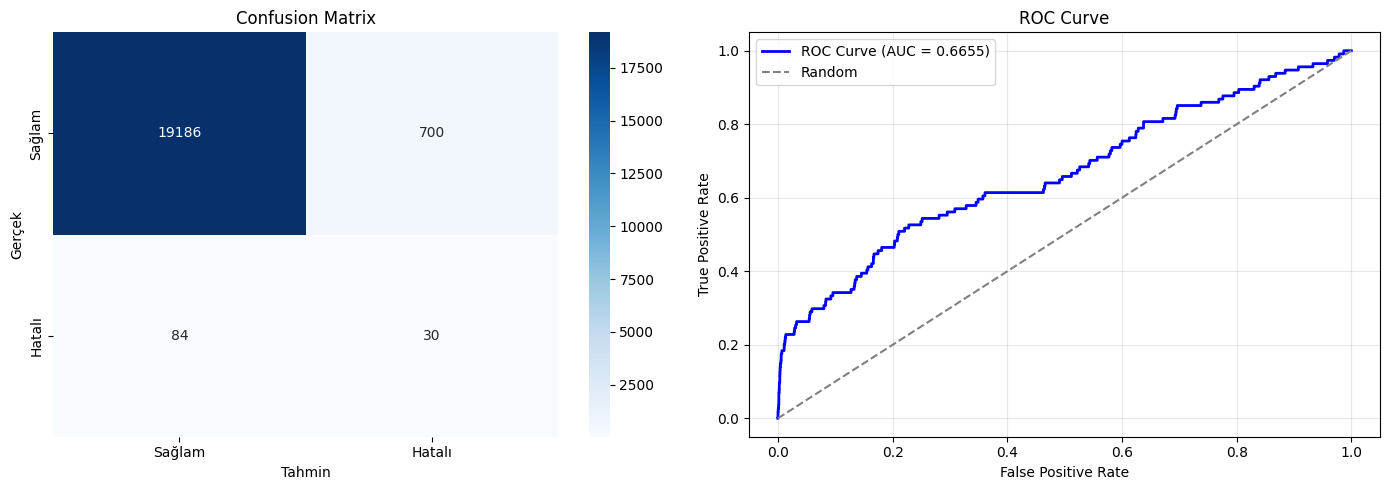

In [8]:
# Confusion Matrix ve ROC Curve görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sağlam', 'Hatalı'],
            yticklabels=['Sağlam', 'Hatalı'])
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/baseline_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Modeli Kaydet

In [9]:
# Model ve feature listesini kaydet
MODEL_PATH = '../models/bosch_quality_classifier.pkl'
FEATURES_PATH = '../models/feature_columns.pkl'

# Model kaydet
joblib.dump(model, MODEL_PATH)
print(f"✅ Model kaydedildi: {MODEL_PATH}")

# Feature sütunlarını kaydet (inference için gerekli)
feature_columns = X_cleaned.columns.tolist()
joblib.dump(feature_columns, FEATURES_PATH)
print(f"✅ Feature listesi kaydedildi: {FEATURES_PATH}")

# Preprocessing bilgilerini kaydet
preprocessing_info = {
    'dropped_columns': cols_to_drop,
    'fill_value': -999,
    'n_features': len(feature_columns)
}
joblib.dump(preprocessing_info, '../models/preprocessing_info.pkl')
print(f"✅ Preprocessing bilgileri kaydedildi")

✅ Model kaydedildi: ../models/bosch_quality_classifier.pkl
✅ Feature listesi kaydedildi: ../models/feature_columns.pkl
✅ Preprocessing bilgileri kaydedildi


## 📋 Baseline Özeti

### Model Bilgileri:
- **Model:** XGBoost Classifier
- **Özellik Sayısı:** ~330 (>%90 eksik olanlar çıkarıldı)
- **Dengesizlik Stratejisi:** scale_pos_weight

### Sonraki Adımlar:
1. **Feature Engineering:** Yeni özellikler türetmek
2. **Hyperparameter Tuning:** GridSearch ile optimizasyon
3. **Threshold Optimization:** F1 için optimal eşik değeri bulmak

✅ **Baseline model hazır! Şimdi API ve UI'ı test edebiliriz.**